# KOH Posterior Analysis using Mici

This notebook looks at the different ways to implement an MCMC algorithm using Gaussian random-walk Metropolis proposal under the Mici framework.

The goal is to discover the best set-up and compare results against the MATLAB code previously implemented.

First, import the required packages and set up the KOH and Mici frameworks.

In [1]:
import model1 as mm
from dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from MATLAB_mappings import ell2rho, beta2ell
from jax import jit, grad

import numpy as np
import mici

import matplotlib.pyplot as plt

import arviz

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
seed = 1234
n_chain = 1
n_dim = 7
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    map0inftoR(beta2ell(2)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])

param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0])
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
        mapRto0inf(x[3]),
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6]), 
        mapRto0inf(x[7])
    ]
]

tmax = 0.6
tmin = 0.2


##### KOH Model #####
dataloader = DataLoader('data/simple_field.csv', 'data/simple_comp.csv')
data = dataloader.get_data() # loads normalised/standardised data
model = mm.MatlabModel(*data)
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(
    grad(
        model.get_KOH_neg_log_pos_dens_func(
            param_transform_mici_to_gpjax
        )
    )
)

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
# system = mici.systems.EuclideanMetricSystem(
#     neg_log_dens=jitted_neg_log_posterior_density,
#     grad_neg_log_dens=grad_neg_log_posterior_density,
# )
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

## Setup 1

Adapters:
- DualAveragingStepSizeAdapter(0.234)
- OnlineCovarianceMetricAdapter()

Results:
- Fails to achieve the target acceptance rate of 0.234, instead achieves around 0.2
- ESS bulk values are very similar for each variable.
- Parameter estimate for $\theta$ is very good. 
- 

In [3]:
##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'theta': state.pos[0], 
        'ell_eta_1': state.pos[1], 
        'ell_eta_2': state.pos[2],
        'ell_delta_1': state.pos[3],
        'lambda_eta': state.pos[4],
        'lambda_delta': state.pos[5],
        'lambda_epsilon': state.pos[6],
        'lambda_epsilon_eta': state.pos[7],
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

Sampling stage: Initial fast adaptive [00:02] > Slow adaptive (1/7) [00:00] > Slow adaptive (2/7) [00:00] > Slow adaptive (3/7) [00:01] > Slow adaptive (4/7) [00:03] > Slow adaptive (5/7) [00:05] > Slow adaptive (6/7) [00:11] > Slow adaptive (7/7) [00:36] > Final fast adaptive [00:01] > Main non-adaptive [02:50]

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Chain 1/1: 100%|██████████|10000/10000 [02:50<00:00, 58.80it/s, accept_stat=0.937]

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/mici/systems.py:189: RuntimeWarning: invalid value encountered in add
  return self.h1(state) + self.h2(state)


In [4]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.261,0.141,-0.520,0.018,0.006,0.004,558.0,810.0,NaN
ell_eta_1,-2.334,0.032,-2.397,-2.278,0.001,0.001,487.0,1189.0,NaN
ell_eta_2,-0.954,0.055,-1.058,-0.851,0.002,0.002,598.0,1347.0,NaN
ell_delta_1,-57.296,36.233,-114.532,-2.381,30.681,29.250,2.0,21.0,NaN
lambda_eta,-1.337,0.203,-1.732,-0.970,0.009,0.006,572.0,1014.0,NaN
lambda_delta,3.505,0.274,2.980,4.002,0.011,0.008,631.0,1024.0,NaN
lambda_epsilon,9.066,0.340,8.454,9.724,0.015,0.011,502.0,828.0,NaN
lambda_epsilon_eta,11.268,0.108,11.074,11.476,0.005,0.003,513.0,930.0,NaN


In [5]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

theta :  -0.26069045296457427 ± 0.14130338671954001
ell_eta_1 :  -2.334498975715364 ± 0.031950972252646724
ell_eta_2 :  -0.9539430236138098 ± 0.054604542642366735
ell_delta_1 :  -57.29566529714916 ± 36.231124462921386
lambda_eta :  -1.336879331977974 ± 0.20263585050331145
lambda_delta :  3.504804564821329 ± 0.27440750156515836
lambda_epsilon :  9.065538420254867 ± 0.33982935823907734
lambda_epsilon_eta :  11.267889563925843 ± 0.10845497568732594


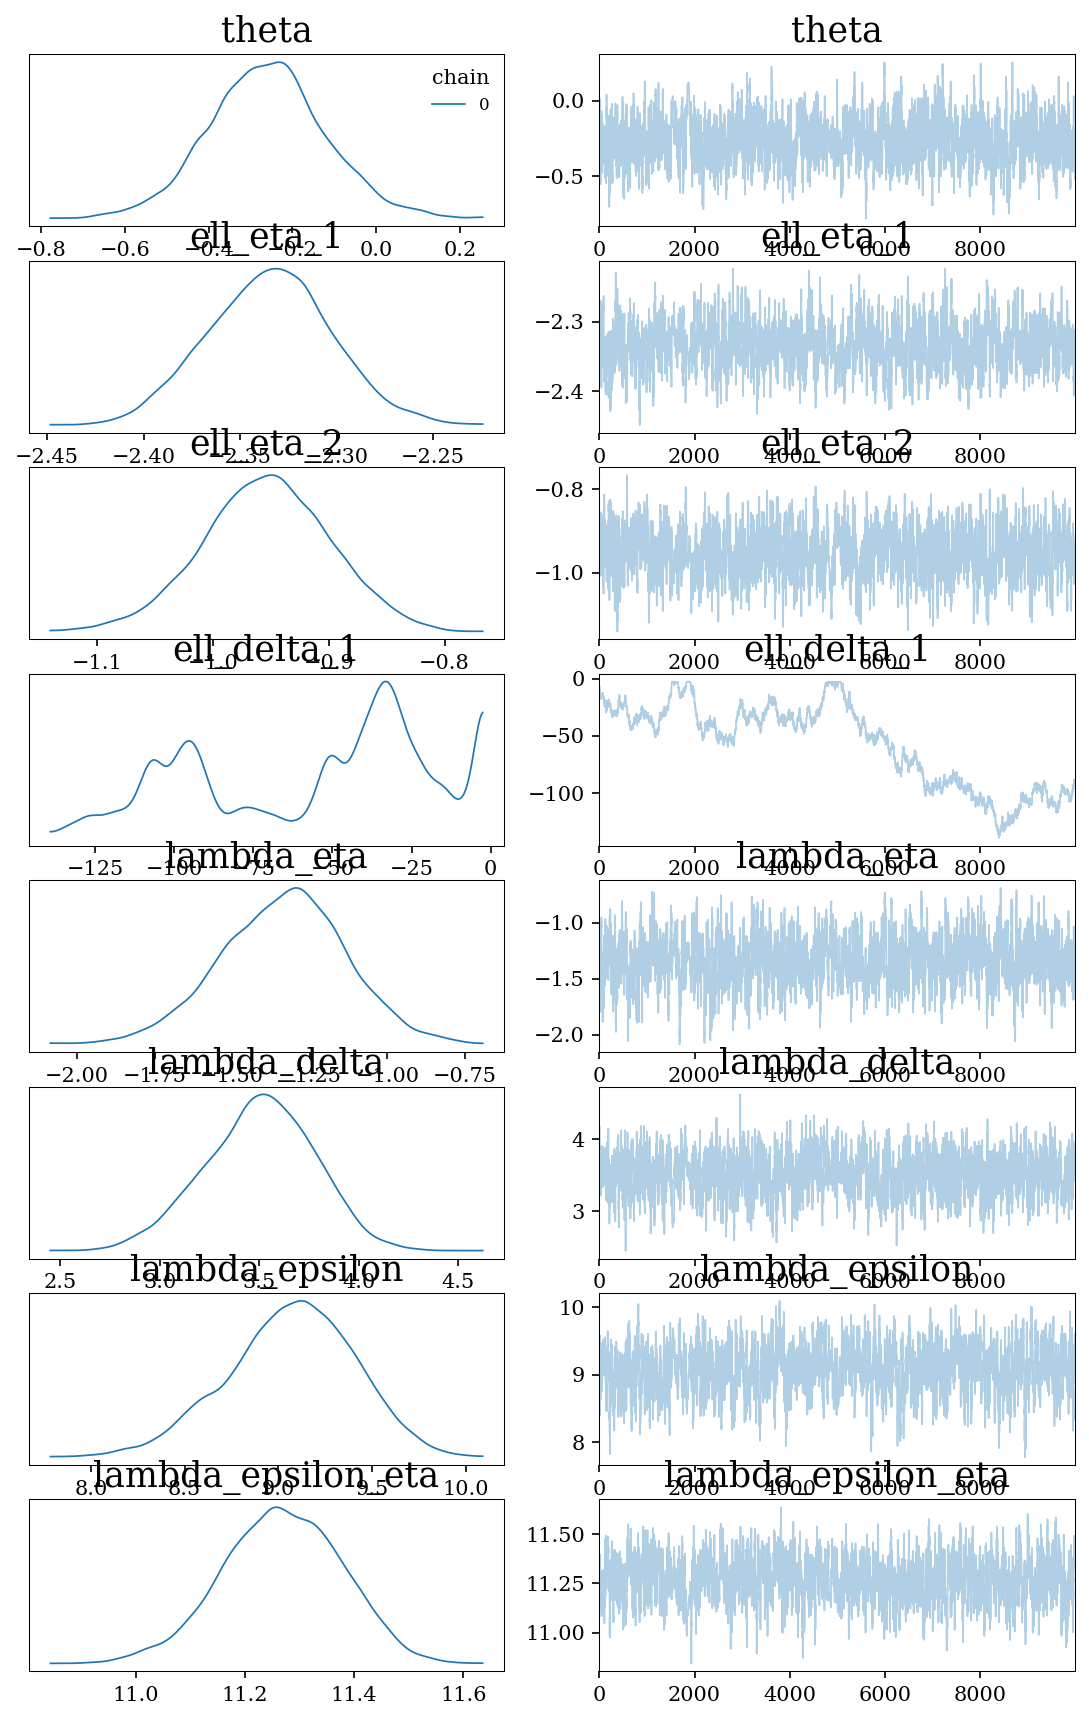

In [6]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )


# Transform the Chains

In [7]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'theta':
        traces_transformed[var] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var == 'ell_eta_1' or var == 'ell_eta_2':
        traces_transformed[var] = ell2rho(mapRto0inf(trace[0]))
    else:
        traces_transformed[var] = mapRto0inf(trace[0])

for var, trace in traces_transformed.items():
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.42579840225403087 ± 0.013835025020138876
ell_eta_1 :  2.2517688558631045e-06 ± 2.101818277922683e-06
ell_eta_2 :  0.43036763810544737 ± 0.039460729846900314
ell_delta_1 :  0.0025144493119598032 ± 0.011772926444138002
lambda_eta :  0.2680663595581097 ± 0.05420498655673915
lambda_delta :  34.53397776901529 ± 9.448964232036714
lambda_epsilon :  9150.387266695157 ± 3048.418687460749
lambda_epsilon_eta :  78727.09099609981 ± 8499.652471938924


In [8]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.426,0.014,0.400,0.453,0.001,0.000,558.0,771.0,NaN
ell_eta_1,0.000,0.000,0.000,0.000,0.000,0.000,487.0,1189.0,NaN
ell_eta_2,0.430,0.039,0.355,0.504,0.002,0.001,598.0,1347.0,NaN
ell_delta_1,0.003,0.012,0.000,0.001,0.001,0.001,2.0,21.0,NaN
lambda_eta,0.268,0.054,0.171,0.372,0.002,0.002,572.0,1014.0,NaN
lambda_delta,34.534,9.449,18.167,51.873,0.364,0.257,631.0,1024.0,NaN
lambda_epsilon,9150.387,3048.571,3928.102,14819.921,132.926,94.045,502.0,828.0,NaN
lambda_epsilon_eta,78727.091,8500.077,63033.403,94672.659,374.516,264.973,513.0,930.0,NaN


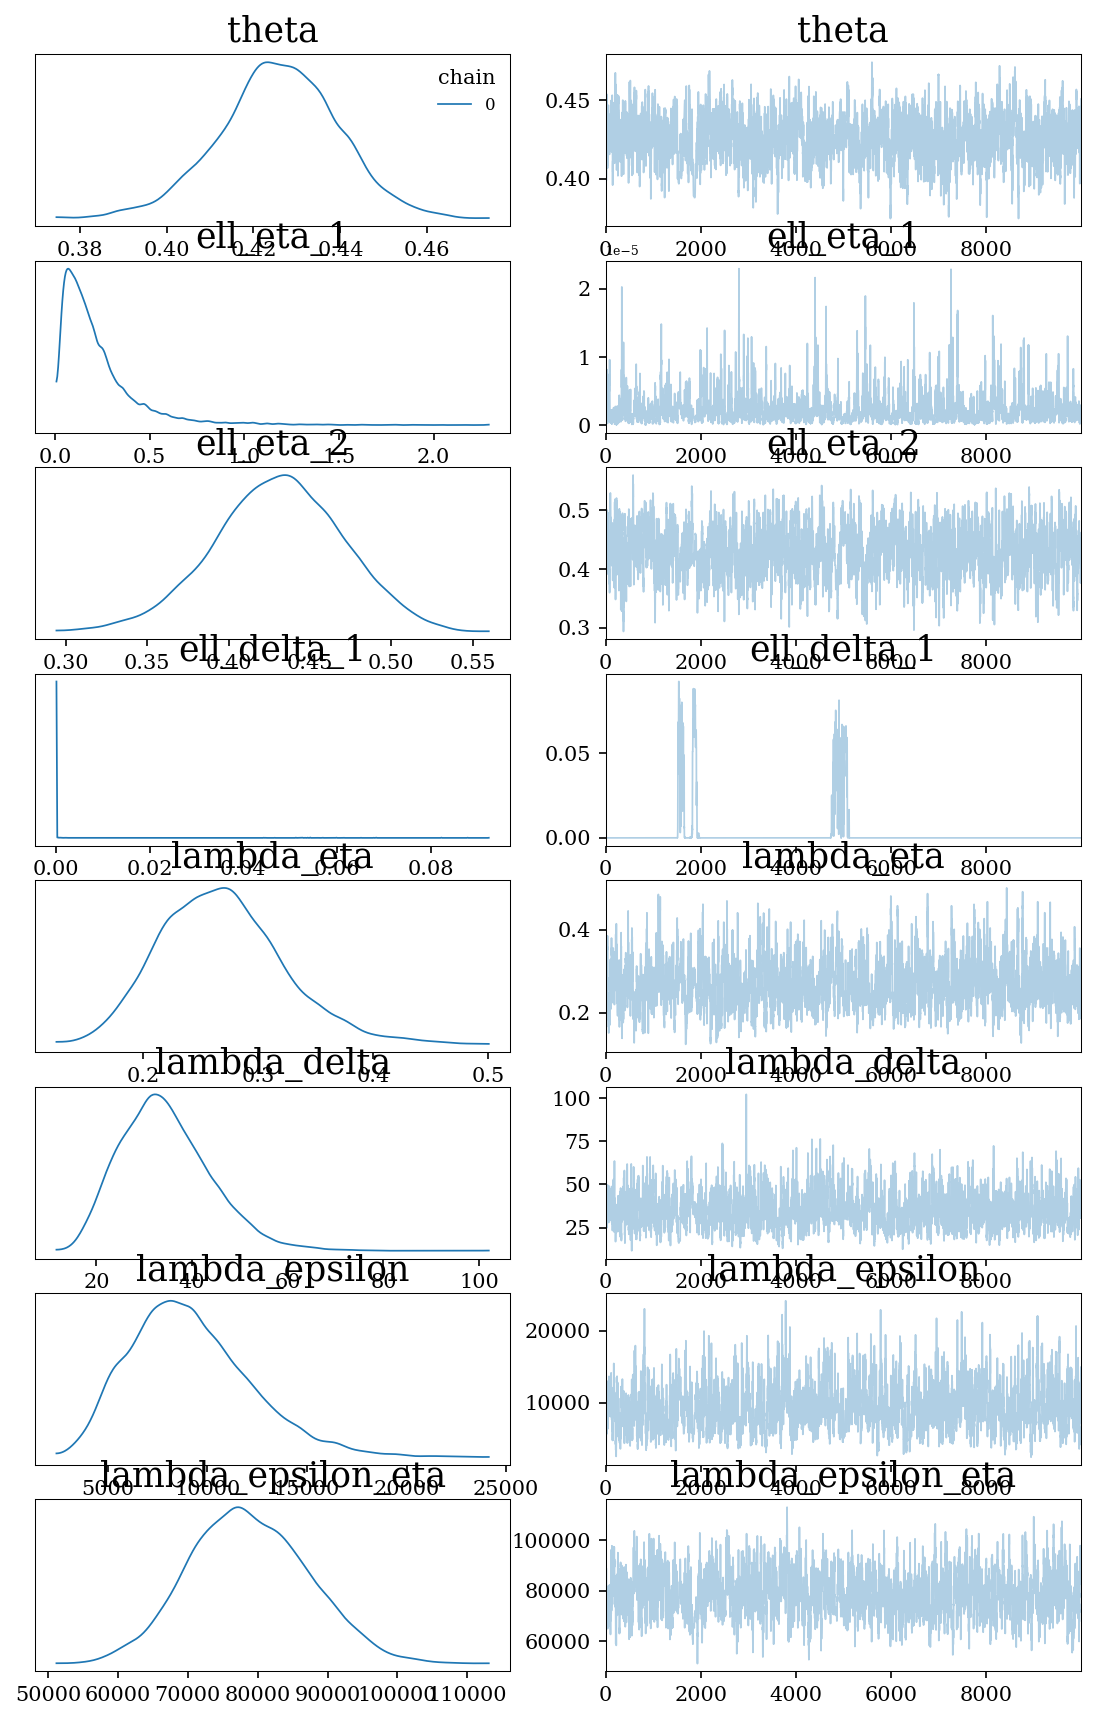

In [9]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()